# Learning About LSM Datasets
### Toy (Metabolic) Dataset

This notebook take the dataset builder format, common in scenic and the LSM codebase, and simplifies it to help people get accustomed with the topic.

Currently this dataset pulls from the metabolic health dataset.
Thus, running this pipeline requires metabolic health AoD access.
This will break if the dataset is moved / deleted.
TODO(girishvn): In future versions change this notebook to NOT depend on AoD gated data. Instead add some sample tfrecords to read from.



## Setup

In [ ]:
# @title Imports

import os
import io
import functools
from typing import Any, Callable, Dict, Iterator, Tuple, Optional, Type, Union
import time
from collections import Counter
import time
import random

from absl import logging
from clu import metric_writers
from clu import periodic_actions
from clu import platform

import flax
from flax import jax_utils
import flax.linen as nn
import jax
import jax.numpy as jnp
import jax.profiler

import pandas as pd
import ml_collections
import numpy as np
import tensorflow as tf

import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload
from colabtools import adhoc_import

with adhoc_import.Google3():

  from scenic.dataset_lib import dataset_utils

  from google3.experimental.largesensormodels.scenic.datasets import dataset_constants
  from google3.experimental.largesensormodels.scenic.datasets import dataset_utils as lsm_dataset_utils  # pylint: disable=unused-import
  from google3.experimental.largesensormodels.scenic.datasets import lsm_v2_metabolic_health_dataset
  from google3.experimental.largesensormodels.scenic.datasets import get_dataset
  from google3.experimental.largesensormodels.scenic.models.lsm_vit_utils import model_constants
  from google3.pyglib import gfile


# Type aliases
Batch = Dict[str, jnp.ndarray]
MetricFn = Callable[
    [jnp.ndarray, jnp.ndarray, Dict[str, jnp.ndarray]],
    Dict[str, Tuple[float, int]],
]
LossFn = Callable[
    [jnp.ndarray, Batch, Optional[jnp.ndarray], jnp.ndarray], float
]
LrFns = Dict[str, Callable[[jnp.ndarray], jnp.ndarray]]
Patch = Union[Tuple[int, int], Tuple[int, int, int]]






In [ ]:
# @title Update Data Constants

# Simplified from:
# experimental/largesensormodels/scenic/datasets/dataset_constants.py

# Notes from @girishvn:
# The data constants file / dictionary holds useful information about each
# dataset that is nice to have when constructing the dataset (e.g. number of samples, number of classes, class sample distribution, etc.)
# It is only (?) reference in the dataset loader (the next cell) and similar files.

# Data constants
MINUTES_IN_ONE_DAY = 1440
MINUTES_IN_ONE_WEEK = 10080
NUM_SENSOR_FEATS_LSM_V2 = 26  # number of sensor features in the V2 dataset.

lsm_dataset_constants: Dict[str, Any] = {
    'metabolic_tfrecords_24h_missingness_80': {
        'dataset_name': 'metabolic_tfrecords_24h_missingness_80',
        'dataset_dir': (
            '/namespace/fitbit-medical-sandboxes/jg/partner/encrypted/chr-ards-metabolichealth/deid/exp/aliheydari/'
        ),
        'num_train_examples': 54385,
        'num_test_examples': 10664,
        'feature_shape': (MINUTES_IN_ONE_DAY, NUM_SENSOR_FEATS_LSM_V2, 1),
        'data_split_id': 70467,

        # Task details
        'hypertension_binary': {
            'label_values': [0, 1],
            'label_names': ['Negative', 'Positive'],
            'label_counts': [41843, 12542],
            'label_weights': None,
        },
    },
}

# Update data constants package with above simplified data constants.
dataset_constants.lsm_dataset_constants = lsm_dataset_constants

print(f'Printing Simplified Data Constants Dict...\n\n{dataset_constants.lsm_dataset_constants}')

Printing Simplified Data Constants Dict...

{'metabolic_tfrecords_24h_missingness_80': {'dataset_name': 'metabolic_tfrecords_24h_missingness_80', 'dataset_dir': '/namespace/fitbit-medical-sandboxes/jg/partner/encrypted/chr-ards-metabolichealth/deid/exp/aliheydari/', 'num_train_examples': 54385, 'num_test_examples': 10664, 'feature_shape': (1440, 26, 1), 'data_split_id': 70467, 'hypertension_binary': {'label_values': [0, 1], 'label_names': ['Negative', 'Positive'], 'label_counts': [41843, 12542], 'label_weights': None}}}


In [ ]:
# @title Data Loader

# This is a simplified version of the dataset implemented here:
# experimental/largesensormodels/scenic/datasets/lsm_v2_metabolic_health_dataset.py

# Notes from @girishvn:
# This is the dataloader file. There is a lot of confusing logic here, mostly
# centered on taking a dataset and distributing among different TPU devices.
# More concretely, the get_metabolic_health_dataset function, loads the tf
# examples (data samples) from a number of tf record files. These are then split
# into train/val splits. These splits are then parsed (tfrecords hold encoded
# data so you need to decode them) - done in parse_metabolic_tfrecord.
# The dataset is the preprocessed (preprocess_example) (type casting the
# parameters), and then one-hot-encoded for the task we want to use (in this
# case we are looking at binary hypertension). The data splits, along with some
# metadata are added to a dataset class (defined by the scenic framework).
# This function is called by the get dataset function, which splits the data
# correctly across devices.

def task_preprocess_example(example, task_name, ohe_binary_task=True):
  """Preprocesses the given example for a given downstream task."""

  unprocessed_label = example[task_name]

  # Preprocess binary tasks.
  # 'binray' to account for misspelled label 'homa_ir_binray'.
  if (
      'binary' in task_name or
      'binray' in task_name or
      task_name == 'respiratory'
  ):
    # Treat as a 2-class multi-class softmax task.
    if ohe_binary_task:
      label = tf.one_hot(unprocessed_label, 2)
    # Treat as a 1-class binary detection task.
    else:
      label = unprocessed_label

  else:
    raise ValueError(f'Task name {task_name} is not yet supported.')

  return {
      'input_signal': example['input_signal'],
      'label': label,
      'unprocessed_label': unprocessed_label,
  }


def preprocess_example(example, dataset_name, dtype=tf.float32):  # pylint: disable=unused-argument
  """Preprocesses the given example.

  Adapted from google3/third_party/py/scenic/dataset_lib/cifar10_dataset.py
  """

  # Type cast and add channel dimension to input signal.
  feature = tf.cast(example['input_signal'], dtype)
  feature = tf.expand_dims(feature, axis=-1)  # Add channel dimension.
  example['input_signal'] = feature
  return example


def parse_metabolic_tfrecord(example):
  """Parse example from TFRecord feature.

  Args:
    example: tf.Example; Example to parse.

  Returns:
    A parsed example.
  """

  # FEATURE WITH ALL LABELS
  feature = {
      # Demographic Labels
      'bmi': tf.io.FixedLenFeature([], tf.float32),  # body mass index
      'age': tf.io.FixedLenFeature([], tf.int64),
      'gender': tf.io.FixedLenFeature([], tf.int64),

      # Binary Clinical Outcome Labels
      'hypertension_binary': tf.io.FixedLenFeature([], tf.int64),

      # Input Signal
      'array_raw': tf.io.FixedLenFeature([], tf.string),
  }

  # Convert raw array to float array input
  example = example['example']
  example = tf.io.parse_single_example(example, feature)
  example['input_signal'] = tf.io.parse_tensor(
      example['array_raw'], out_type=tf.double
  )
  example.pop('array_raw')  # remove raw input signal
  return example


def get_metabolic_health_dataset(
    *,
    config: ml_collections.ConfigDict,
    num_shards: int,
    batch_size: int,
    eval_batch_size: Optional[int] = None,
    dtype_str: str = 'float32',
    shuffle_seed: int = 0,
    rng: Optional[jnp.ndarray] = None,
    shuffle_buffer_size: Optional[int] = None,
    dataset_service_address: Optional[str] = None,
    data_dir: str = '/namespace/fitbit-medical-sandboxes/jg/partner/encrypted/chr-ards-metabolichealth/deid/exp/aliheydari/'
):
  """Gets and formats the LSM V2 Metabolic Health Dataset.
  """
  # Setup: General
  del rng  # rng is currently unused (no random augmentations used).

  # 1. Process information.
  p_idx = jax.process_index()  # current process index
  p_cnt = jax.process_count()  # process count (number of processes)

  # 2. dataset and data type information.
  dataset_configs = config.dataset_configs  # get dataset configurations.
  dataset_name = dataset_configs.dataset  # get ds name
  # Repeat dataset flag. Not repeating the datasets (repeat_flag=False) is
  # helpful for examining and debugging the dataset.
  repeat_flag = dataset_configs.get('repeat_data', True)  # repeat dataset
  dtype = getattr(tf, dtype_str)  # data dtype
  if eval_batch_size is None:  # set eval batch size
    eval_batch_size = batch_size

  # Get dataset constants.
  dataset_consts_dict = dataset_constants.lsm_dataset_constants[dataset_name]

  # Setup: Data splits.
  # 1. Train / Val Split
  load_data_dir = os.path.join(data_dir, dataset_name)
  data_fpattern = os.path.join(load_data_dir, '*.tfrecords')
  filenames = gfile.Glob(data_fpattern)  # get dataset files
  filenames.sort()  # sort file names for deterministic split

  # Split into train and eval
  # Splitting is done based on subject id.
  ds_split_id = dataset_consts_dict['data_split_id']
  train_files = []
  val_files = []
  for f in filenames:
    _, fname = os.path.split(f)
    subj_id = int(fname.replace('.tfrecords', '').split('_')[-1])
    if subj_id < ds_split_id:
      train_files.append(f)
    else:
      val_files.append(f)

  # Assert files exist and log file counts.
  assert train_files
  assert val_files
  logging.info('Number of train files: %d', len(train_files))
  logging.info('Number of val files: %d', len(val_files))

  # Convert to tf.data.Dataset
  train_files = tf.data.Dataset.from_tensor_slices(train_files)
  val_files = tf.data.Dataset.from_tensor_slices(val_files)

  # Interleave data examples, and add filepath information.
  # This is a bit of a hack used for getting subject ID
  # Contact girishvn if you need help.
  train_ds = train_files.interleave(  # Get dataset
      lambda filename: tf.data.TFRecordDataset(filename).map(
          lambda example: {'filepath': filename, 'example': example}
      ),
      num_parallel_calls=tf.data.experimental.AUTOTUNE,
  )
  val_ds = val_files.interleave(
      lambda filename: tf.data.TFRecordDataset(filename).map(
          lambda example: {'filepath': filename, 'example': example}
      ),
      num_parallel_calls=tf.data.experimental.AUTOTUNE,
  )

  # Split dataset accross devices.
  num_train_examples = dataset_consts_dict['num_train_examples']
  num_val_examples = dataset_consts_dict['num_test_examples']
  p_train_cnt = num_train_examples // p_cnt
  p_val_cnt = num_val_examples // p_cnt

  train_start = p_idx * p_train_cnt
  val_start = p_idx * p_val_cnt
  if p_idx == p_cnt - 1:
    train_ds = train_ds.skip(train_start)
    val_ds = val_ds.skip(val_start)
  else:
    train_ds = train_ds.skip(train_start).take(p_train_cnt)
    val_ds = val_ds.skip(val_start).take(p_val_cnt)

  # Data processing and preperation.
  # 0. Enable multi threaded workers.
  options = tf.data.Options()
  options.threading.private_threadpool_size = 48
  train_ds = train_ds.with_options(options)
  val_ds = val_ds.with_options(options)

  # 0. Parse tfrecord.
  parse_fn = functools.partial(parse_metabolic_tfrecord)
  train_ds = train_ds.map(
      parse_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE
  )
  val_ds = val_ds.map(
      parse_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE
  )

  # 1. Preprocessing, augmentation, and cropping/padding functions.
  # Preprocessing: Applied before `ds.cache()` to re-use it.
  preprocess_fn = functools.partial(
      preprocess_example, dataset_name=dataset_name, dtype=dtype
  )
  train_ds = train_ds.map(
      preprocess_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE
  )
  val_ds = val_ds.map(
      preprocess_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE
  )

  # 2. Add task labels.
  task_name = dataset_configs.task_name
  task_preprocess_fn = functools.partial(
      task_preprocess_example,
      task_name=task_name,
  )
  train_ds = train_ds.map(
      task_preprocess_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE
  )
  val_ds = val_ds.map(
      task_preprocess_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE
  )

  # 2. Cache datasets: This can signficantly speed up training.
  if dataset_configs.cache_dataset:
    train_ds = train_ds.cache()
    val_ds = val_ds.cache()

  # 3 Train repeats and augmentations.
  if repeat_flag:
    train_ds = train_ds.repeat()  # repeat

  # 6. Data preperation (shuffling, augmentations, batching, eval repeat, etc.).
  # 6a. Train: Shuffle, batch, prefetch
  shuffle_buffer_size = shuffle_buffer_size or (8 * batch_size)
  train_ds = train_ds.shuffle(shuffle_buffer_size, seed=shuffle_seed)
  train_ds = train_ds.batch(batch_size, drop_remainder=True)  # batch
  train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)  # prefetch

  # 6b. Validation: Batch, Repeat, Prefetch
  val_ds = val_ds.batch(batch_size, drop_remainder=False)  # batch
  if repeat_flag:
    val_ds = val_ds.repeat()  # repeat
  val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)  # prefetch

  # Ensure that no seed is set if dataset_service_address is defined.
  if dataset_service_address:
    if shuffle_seed is not None:
      raise ValueError(
          'Using dataset service with a random seed causes each '
          'worker to produce exactly the same data. Add '
          'config.shuffle_seed = None to your config if you '
          'want to run with dataset service.'
      )
    train_ds = dataset_utils.distribute(train_ds, dataset_service_address)
    logging.info('Using the tf.data service at %s', dataset_service_address)

  # Other mappings
  # 1. Set up batch padding: If batch remainders are NOT dropped batches may be
  # padded to allow for an enough patches to contain all samples.
  maybe_pad_batches_train = functools.partial(
      dataset_utils.maybe_pad_batch,
      train=True,
      batch_size=batch_size,
      inputs_key='input_signal',
  )
  maybe_pad_batches_eval = functools.partial(
      dataset_utils.maybe_pad_batch,
      train=False,
      batch_size=eval_batch_size,
      inputs_key='input_signal',
  )

  # 2. Set up batch sharding: Shard batches to be processed by multiple devices.
  shard_batches = functools.partial(dataset_utils.shard, n_devices=num_shards)

  # 3. Apply other mappings and Iter dataset
  train_iter = iter(train_ds)
  train_iter = map(dataset_utils.tf_to_numpy, train_iter)
  train_iter = map(maybe_pad_batches_train, train_iter)
  train_iter = map(shard_batches, train_iter)

  val_iter = iter(val_ds)
  val_iter = map(dataset_utils.tf_to_numpy, val_iter)
  val_iter = map(maybe_pad_batches_eval, val_iter)
  val_iter = map(shard_batches, val_iter)

  # Save meta data
  original_input_shape = dataset_consts_dict['feature_shape']
  original_input_shape = tuple([-1] + list(original_input_shape))
  num_classes = len(dataset_consts_dict[task_name]['label_values'])
  meta_data = {
      'input_shape': original_input_shape,
      'num_train_examples': num_train_examples,
      'num_val_examples': num_val_examples,
      'num_test_examples': 0,
      'input_dtype': getattr(jnp, dtype_str),
      'target_is_onehot': True,
      'num_classes': num_classes,
      'task_name': task_name,
  }

  # Return dataset structure.
  return dataset_utils.Dataset(train_iter, val_iter, None, meta_data)



# Set up get dataset function.
# This is a simplified version branched from here:
#

In [ ]:
# @title Get and Format Dataset

# Set up get dataset function.
# This is a simplified version branched from here:
# experimental/largesensormodels/scenic/datasets/get_dataset.py

# Notes from @girishvn:
# This function takes a dataset loader/builder and makes sure that the dataset
# is constructed correctly to be run across multiple devices
# (local_batch_size = batch_size // jax.process_count()).

def get_dataset(
    config: Any,
    data_rng: jnp.ndarray,
    *,
    num_local_shards: Optional[int] = None,
    dataset_service_address: Optional[str] = None,
    **kwargs: Any,
) -> dataset_utils.Dataset:
  """Adapted from: google3/third_party/py/scenic/train_lib/train_utils.py."""

  # Get device count
  device_count = jax.device_count()

  # Get dataset builder.
  dataset_builder = get_metabolic_health_dataset  # this builder is defined above

  # Get batch size
  batch_size = config.batch_size
  if batch_size % device_count > 0:
    raise ValueError(
        f'Batch size ({batch_size}) must be divisible by the '
        f'number of devices ({device_count})'
    )

  local_batch_size = batch_size // jax.process_count()
  device_batch_size = batch_size // device_count

  # Get shuffle seed - ensure it exists
  shuffle_seed = config.get('shuffle_seed', None)
  # Get shuffle buffer size.
  shuffle_buffer_size = config.dataset_configs.get('shuffle_buffer_size', None)
  # Local shard count.
  num_local_shards = num_local_shards or jax.local_device_count()

  # Build the dataset
  ds = dataset_builder(
      config=config,
      num_shards=num_local_shards,
      batch_size=local_batch_size,
      dtype_str=config.data_dtype_str,
      shuffle_seed=shuffle_seed,
      rng=data_rng,
      shuffle_buffer_size=shuffle_buffer_size,
      dataset_service_address=dataset_service_address,
      **kwargs,
  )

  return ds


In [ ]:
# @title Example of an LSM Config

# Notes from @girishvn:
# This is a config, used in the LSM modeling code. This configs are used for
# both dataset construction (passed to the dataloader) and training.
# Most of the things here can be ignored, though there are some configs used to
# form the dataset. This is specifically a config for a ResNet model used with
# the metabolic dataset. Most of the parameters can be ignored (for now) but are
# useful for training.

# To set constants.
# 1) Dataset / task variables.
DATASET_NAME = 'metabolic_tfrecords_24h_missingness_80'
TASK_NAME = [
    'hypertension_binary',
]

CACHE_DATASET = True
TRAIN_DATA_SIZE = None
USE_DATETIME_FEATURES = False
USE_TRAIN_AUGMENTATIONS = [False]
TRAIN_AUGMENTATIONS = ['noise']
SHUFFLE_SEED = 42
SHUFFLE_BUFFER_SIZE = 10_000

# 2) Model variables.
VARIANT = ['metadata_encoded_resnet', 'resnet']
NUM_LAYERS = [18, 50]
# NUM_LAYERS = [200]  # Needs glp_2x2
NUM_FILTERS = 64
METADATA_ENCODING_FN = 'concat'

# 3) Loss variables.
LOSS_FN = ['balanced_softmax_loss']  # ['weighted_softmax_cross_entropy']
WEIGHTED_LOSS = [False]  # whether or not to use label weights
LABEL_SMOOTHING = [None]

# 3) Training / eval variables.
BATCH_SIZE = 1024
NUM_TRAIN_STEPS = 500

# Optimizer variables.
LRS = [5e-3]
WEIGHT_DECAYS = [1e-4]

# 4) Logging variables.
LOG_EVAL_SUMMARY_STEPS = 25  # STEPS_PER_EPOCH
LOG_CHECKPOINT_STEPS = 25  # LOG_EVAL_SUMMARY_STEPS * 5
MAX_NUM_CHECKPOINTS = int(NUM_TRAIN_STEPS / LOG_CHECKPOINT_STEPS)


def get_config(runlocal=''):
  """Returns the ViT experiment configuration."""

  runlocal = bool(runlocal)

  # 1. Experiment.
  config = ml_collections.ConfigDict()
  config.experiment_name = f'resnet-supervised-{DATASET_NAME}'
  config.shuffle_seed = SHUFFLE_SEED

  # 2. Dataset.
  config.data_dtype_str = 'float32'
  config.dataset_configs = ml_collections.ConfigDict()
  config.dataset_configs.dataset = DATASET_NAME
  config.dataset_configs.cache_dataset = CACHE_DATASET
  config.dataset_configs.prefetch_to_device = 2
  # Shuffle_buffer_size is per host, so small-ish is ok.
  config.dataset_configs.shuffle_buffer_size = (
      None if runlocal else SHUFFLE_BUFFER_SIZE
  )

  config.dataset_configs.relative_time_window = None
  config.dataset_configs.task_name = TASK_NAME[0]

  # 3. Model.
  config.model_name = VARIANT[0]
  config.model = ml_collections.ConfigDict()
  config.model.patcher_config = ml_collections.ConfigDict()
  config.model.patcher_config.patchsize = None  # No patching is ResNet.
  config.model.num_layers = NUM_LAYERS[0]
  config.model.num_filters = NUM_FILTERS
  config.model.metadata_encoding_fn = METADATA_ENCODING_FN

  # 4. Model Loss
  config.classification_loss = ml_collections.ConfigDict()
  config.classification_loss.loss_name = LOSS_FN[0]
  config.classification_loss.label_smoothing = LABEL_SMOOTHING[0]
  config.classification_loss.weighted_loss = WEIGHTED_LOSS[0]

  # 5. Datetime features.
  config.use_datetime_features = USE_DATETIME_FEATURES

  # Training.
  config.trainer_name = 'lsm_supervised_trainer'
  config.batch_size = 8 if runlocal else BATCH_SIZE
  config.num_training_steps = 10 if runlocal else NUM_TRAIN_STEPS
  config.steps_per_eval = 10 if runlocal else None
  config.log_eval_steps = LOG_EVAL_SUMMARY_STEPS
  config.log_summary_steps = LOG_EVAL_SUMMARY_STEPS
  config.rng_seed = 42
  config.use_train_augmentations = USE_TRAIN_AUGMENTATIONS[0]
  config.train_augmentations = TRAIN_AUGMENTATIONS

  sched = ml_collections.ConfigDict()
  sched.re = '(.*)'
  sched.lr_configs = ml_collections.ConfigDict()
  sched.lr_configs.learning_rate_schedule = 'compound'
  sched.lr_configs.factors = 'constant * cosine_decay * linear_warmup'
  sched.lr_configs.total_steps = NUM_TRAIN_STEPS
  sched.lr_configs.steps_per_cycle = sched.lr_configs.total_steps
  sched.lr_configs.warmup_steps = int(NUM_TRAIN_STEPS * 0.05)
  sched.lr_configs.base_learning_rate = LRS[0]
  config.schedule = ml_collections.ConfigDict({'all': sched})

  # *Single* optimizer.
  optim = ml_collections.ConfigDict()
  optim.optax_name = 'scale_by_adam'
  # optim.optax = dict(mu_dtype='bfloat16')
  optim.optax_configs = ml_collections.ConfigDict({  # Optimizer settings.
      'b1': 0.9,
      'b2': 0.95,
  })
  config.optax = dict(mu_dtype='bfloat16')
  optim.max_grad_norm = 1.0
  optim.weight_decay = WEIGHT_DECAYS[0]
  optim.weight_decay_decouple = True
  config.optimizer = optim

  # Logging.
  config.write_summary = True
  config.xprof = True  # Profile using xprof.
  config.checkpoint = True  # Do checkpointing.
  config.checkpoint_steps = LOG_CHECKPOINT_STEPS
  config.debug_train = False  # Debug mode during training.
  config.debug_eval = False  # Debug mode during eval.
  config.max_checkpoints_to_keep = MAX_NUM_CHECKPOINTS
  # BEGIN GOOGLE-INTERNAL
  if runlocal:
    # Current implementation fails with UPTC.
    config.count_flops = False
  # END GOOGLE-INTERNAL

  return config


## Load and Visualize Data

In [ ]:
# @title Load Dataset

# Notes from @girishvn:
# Here we get the config - used for dataset construction and training / eval
# We generate a random jax key to use to shuffle the dataset and do other random operations
# We then load the dataset and print the metadata

config = get_config(runlocal=True)  # must be false to get full dataset - true gives a smaller subset (for running local)
data_rng = jax.random.PRNGKey(config.rng_seed)  # construct the random jax seed for data shuffling / augmentations / etc.
dataset = get_dataset(config, data_rng)  # get the dataset

print('Processed Dataset Meta Data:\n')
for k in dataset.meta_data.keys():
  print(k, dataset.meta_data[k])

Processed Dataset Meta Data:

input_shape (-1, 1440, 26, 1)
num_train_examples 54385
num_val_examples 10664
num_test_examples 0
input_dtype <class 'jax.numpy.float32'>
target_is_onehot True
num_classes 2
task_name hypertension_binary


Printing data batch keys
 dict_keys(['batch_mask', 'input_signal', 'label', 'unprocessed_label'])

Plotting data samples...


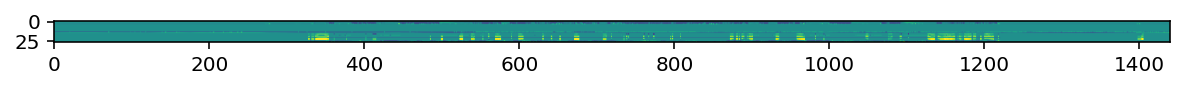

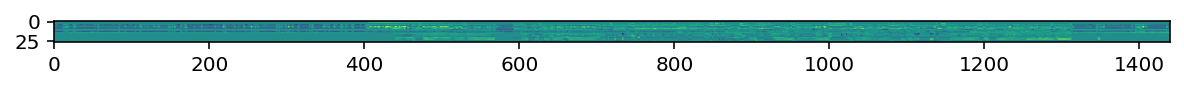

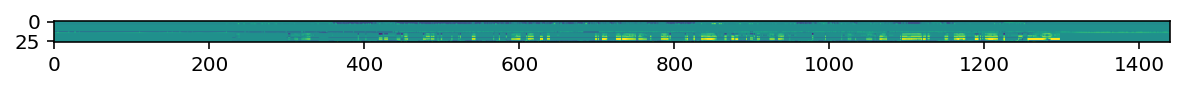

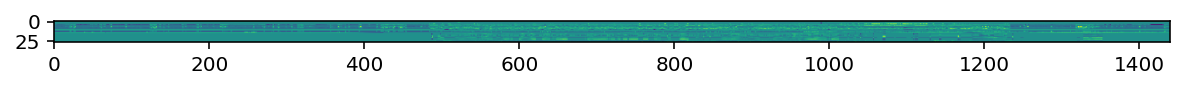

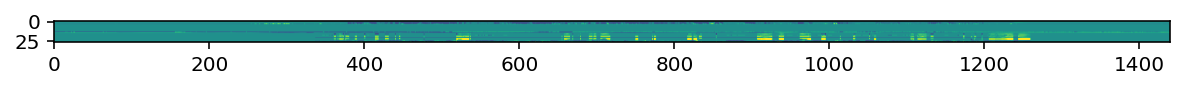

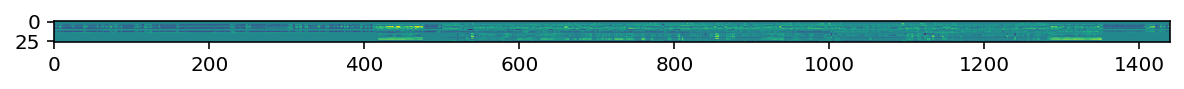

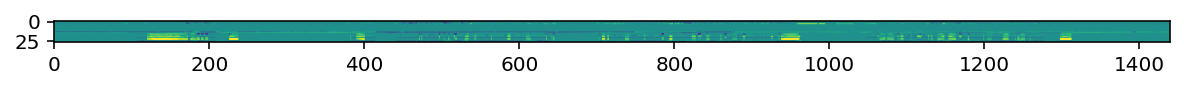

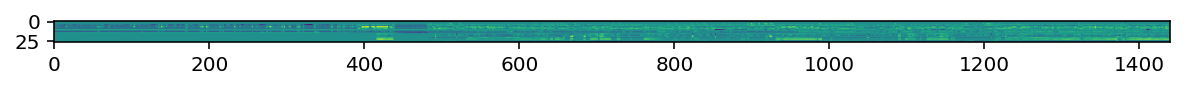

In [ ]:
# @title Visualize a couple samples

batch = next(dataset.valid_iter)
print('Printing data batch keys\n', batch.keys())

print('\nPlotting data samples...')
x = batch['input_signal'][0]
for sample in x:

  sample = jnp.transpose(sample, (1, 0, 2))

  plt.figure(figsize=(10, 5))
  plt.imshow(sample)
  plt.show()